In [1]:
# import lib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.datasets import make_moons,make_classification,make_regression,make_circles
import sys
from mpl_toolkits.mplot3d import Axes3D 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA,KernelPCA
np.random.seed(23)
np.set_printoptions(precision=3,suppress=True)
plt.style.use('seaborn')

import os
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
tf.logging.set_verbosity(tf.logging.ERROR)
from tensorflow.examples.tutorials.mnist import input_data

def _sym_decorrelation(W):
    """ Symmetric decorrelation
    i.e. W <- (W * W.T) ^{-1/2} * W
    """
    s, u = np.linalg.eigh(np.dot(W, W.T))
    # u (resp. s) contains the eigenvectors (resp. square roots of
    # the eigenvalues) of W * W.T
    return np.dot(np.dot(u * (1./(np.sqrt(s+1e-8))+1e-8), u.T), W)

In [2]:
# import data
mnist = input_data.read_data_sets('../../Dataset/MNIST/', one_hot=True)
train_data,train_label,val_data,val_label,test_data,test_label = mnist.train.images,mnist.train.labels,mnist.validation.images,mnist.validation.labels,mnist.test.images, mnist.test.labels
print(train_data.shape,train_label.shape,train_data.max(),train_data.min())
print(val_data.shape,val_label.shape,val_data.max(),val_data.min())
print(test_data.shape,test_label.shape,test_data.max(),test_data.min())

Extracting ../../Dataset/MNIST/train-images-idx3-ubyte.gz
Extracting ../../Dataset/MNIST/train-labels-idx1-ubyte.gz
Extracting ../../Dataset/MNIST/t10k-images-idx3-ubyte.gz
Extracting ../../Dataset/MNIST/t10k-labels-idx1-ubyte.gz
(55000, 784) (55000, 10) 1.0 0.0
(5000, 784) (5000, 10) 1.0 0.0
(10000, 784) (10000, 10) 1.0 0.0


In [3]:
#  create class
def arctan(x):  return tf.arctan(x)
def tan(x)   :  return tf.tan(x)
def d_arctan(x):return 1/(1+x**2)
def d_tanh(x):  return 1/tf.cos(x)

class FNN():
    
    def __init__(self,input,output,act,d_act):
        self.w = tf.Variable(tf.random.normal())
        self.mw,self.mv = np.zeros_like()
        
        self.a = np.ones(output)
        self.b = np.ones(output)
        self.c = np.zeros(output)
        
        self.act  = act
        self.d_act= d_act

In [24]:
def tf_arctan(x): return tf.atan(x)
def tf_tan(x)   : return tf.tan(x)

def d_tf_arctan(x): return 1/(1+x**2)
def d_tf_tan(x):    return 1/(tf.cos(x)**2)

class PCA_Layer():

    def __init__(self,inc,outc,act=tf_arctan,d_act=d_tf_arctan):
        
        if outc == 1:
            self.w = tf.Variable(self.norm(tf.random_normal([inc,outc],stddev=1,seed=2)))
        else:
            self.w = tf.Variable(self.sym_decorrelation(tf.random_normal([inc,outc],stddev=0.05,seed=2)))
        self.a = tf.Variable(tf.ones([outc]))
        self.b = tf.Variable(tf.ones([outc]))
        self.c = tf.Variable(tf.zeros([outc]))
        
        self.mw,self.vw = tf.Variable(tf.zeros_like(self.w)),tf.Variable(tf.zeros_like(self.w))
        self.ma,self.va = tf.Variable(tf.zeros_like(self.a)),tf.Variable(tf.zeros_like(self.a))
        self.mb,self.vb = tf.Variable(tf.zeros_like(self.b)),tf.Variable(tf.zeros_like(self.b))
        self.mc,self.vc = tf.Variable(tf.zeros_like(self.c)),tf.Variable(tf.zeros_like(self.c))
        
        self.act,self.d_act = act,d_act

    def feedforward_linear(self,input_value):
        self.input  = input_value
        self.layer  = tf.matmul(self.input,self.w) 
        loss = tf.transpose(self.w) @ tf.transpose(self.input) @ self.input @ self.w
        return self.layer,loss
    def backprop_linear(self):
        gradw      = -2* tf.transpose(self.input) @ self.input @ self.w
        grad_pass  = -2*self.input@self.w@tf.transpose(self.w)
        
        update_w = []
        update_w.append(tf.assign( self.mw,self.mw*beta1 + (1-beta1) * (gradw)   ))
        update_w.append(tf.assign( self.vw,self.vw*beta2 + (1-beta2) * (gradw ** 2)   ))
        m_hatw = self.mw / (1-beta1)
        v_hatw = self.vw / (1-beta2)
        adam_midw = m_hatw *  learning_rate/(tf.sqrt(v_hatw) + adam_e)
        update_w.append(tf.assign(self.w,self.sym_decorrelation(tf.subtract(self.w,adam_midw ))))
        
        return grad_pass,update_w

    def feedforward_nonlinear(self,input_value):
        self.input  = input_value
        self.layer  = tf.matmul(self.input,self.w) 
        self.layerA = self.a*self.act(self.b*self.layer) + self.c
        loss = tf.transpose(self.w) @ tf.transpose(self.input) @ self.input @ self.w
        return self.layerA,loss
    def backprop_nonlinear(self,gradient):
        
        grada = tf.reduce_mean(gradient * self.act(self.b*self.layer),0)
        gradb = tf.reduce_mean(gradient * self.a * self.d_act(self.b*self.layer) * self.layer,0)
        gradc = tf.reduce_mean(gradient,0)
        gradw = tf.transpose(self.input) @ (gradient * self.a * self.d_act(self.b*self.layer) * self.b) - 2 * tf.transpose(self.input) @ self.input @ self.w
        grad_pass = (gradient * self.a * self.d_act(self.b*self.layer) * self.b) @ tf.transpose(self.w) - 2 * self.input@self.w@tf.transpose(self.w)

        update_w = []
        
        update_w.append(tf.assign( self.mw,self.mw*beta1 + (1-beta1) * (gradw)   ))
        update_w.append(tf.assign( self.vw,self.vw*beta2 + (1-beta2) * (gradw ** 2)   ))
        m_hatw    = self.mw / (1-beta1)
        v_hatw    = self.vw / (1-beta2)
        adam_midw = m_hatw *  learning_rate/(tf.sqrt(v_hatw) + adam_e)
        update_w.append(tf.assign(self.w,self.sym_decorrelation(tf.subtract(self.w,adam_midw))))
        
        update_w.append(tf.assign( self.ma,self.ma*beta1 + (1-beta1) * (grada)   ))
        update_w.append(tf.assign( self.va,self.va*beta2 + (1-beta2) * (grada ** 2)   ))
        m_hata    = self.ma / (1-beta1)
        v_hata    = self.va / (1-beta2)
        adam_mida = m_hata *  learning_rate/(tf.sqrt(v_hata) + adam_e)
        update_w.append(tf.assign(self.a,self.stand(tf.subtract(self.a,adam_mida))))
        
        update_w.append(tf.assign( self.mb,self.mb*beta1 + (1-beta1) * (gradb)   ))
        update_w.append(tf.assign( self.vb,self.vb*beta2 + (1-beta2) * (gradb ** 2)   ))
        m_hatb    = self.mb / (1-beta1)
        v_hatb    = self.vb / (1-beta2)
        adam_midb = m_hatb *  learning_rate/(tf.sqrt(v_hatb) + adam_e)
        update_w.append(tf.assign(self.b,self.stand(tf.subtract(self.b,adam_midb))))
        
        update_w.append(tf.assign( self.mc,self.mc*beta1 + (1-beta1) * (gradc)   ))
        update_w.append(tf.assign( self.vc,self.vc*beta2 + (1-beta2) * (gradc ** 2)   ))
        m_hatc    = self.mc / (1-beta1)
        v_hatc    = self.vc / (1-beta2)
        adam_midc = m_hatb *  learning_rate/(tf.sqrt(v_hatc) + adam_e)
        update_w.append(tf.assign(self.c,self.stand(tf.subtract(self.c,adam_midc))))

        return grad_pass,update_w
    
    def stand(self,w):
        mean,variance = tf.nn.moments(w,0)
        return (w-mean)/(variance+1e-5)
    def norm(self,W):
        W = W/(tf.sqrt(tf.reduce_sum(W**2)+1e-8))
        return W
    def sym_decorrelation(self,W):
        s, u = tf.linalg.eigh(W@tf.transpose(W))
        result = (u * (1./(tf.sqrt(s+1e-5)+1e-5))) @ tf.transpose(u) @ W
        return result


In [25]:
# set the hyper
learning_rate = 0.0000000008
beta1,beta2,adam_e = 0.9,0.999,1e-8
mini_batch_size    = 10

In [30]:
# create layers 
l1 = PCA_Layer(784,128)
l2 = PCA_Layer(128,2)

x = tf.placeholder(tf.float32,[mini_batch_size,784])
full_data = tf.placeholder(tf.float32,[None,784])
flayer1,_ = l1.feedforward_nonlinear(full_data)
flayer2,_ = l2.feedforward_linear(flayer1)

layer1,l1l = l1.feedforward_nonlinear(x)
layer2,l2l = l2.feedforward_linear(layer1)

loss = tf.reduce_mean(l1l) + tf.reduce_mean(l2l)

grad2,grad2_update = l2.backprop_linear()
grad1,grad1_update = l1.backprop_nonlinear(grad2)
grad_update = grad2_update + grad1_update

In [32]:
# start
# sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
val_data_copy = np.copy(val_data)

for iter in range(1):
    
    val_data_copy  = shuffle(val_data_copy)
    for current_batch_index in range(0,len(val_data_copy),mini_batch_size):
        
        current_batch  = val_data_copy[current_batch_index:current_batch_index+mini_batch_size]
        sess_result    = sess.run([loss,grad_update],feed_dict={x:current_batch})
        print('Iter: ',iter,' current batch: ',current_batch_index,"/5000 var: ",sess_result[0],end='\r')


In [33]:
full_embedding = sess.run(flayer2,feed_dict={full_data:val_data})
print(full_embedding.shape)

(5000, 2)


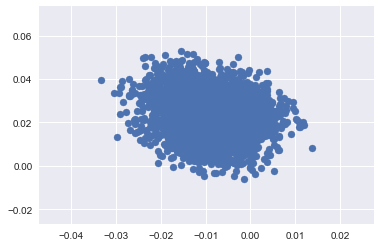

In [34]:
plt.scatter(full_embedding[:,0],full_embedding[:,1])
plt.show()